### Figure 1 (A-D). Systemic antagonism of NMDARs strongly reduced spontaneous calcium activity


Install and import all packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import os
import zipfile
from osfclient import OSF
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks, periodogram, spectrogram, filtfilt, butter, find_peaks_cwt, correlate, welch, peak_prominences, resample

warnings.filterwarnings("ignore")

plt.rcParams.update({
    'font.size': 32, 
    'figure.autolayout': True, 
    'lines.linewidth': 2, 
    'axes.spines.top': False, 
    'axes.spines.right': False
    })

strains = ["Saline", "Non-Selective", "D1-Cre", "A2a-Cre"]

Define Functions

In [2]:
def find_adjust_peaks(signal, widths, min_snr, sr, threshold=0, prominence=0):
    peaks = find_peaks_cwt(signal, widths, min_snr=min_snr)
    
    c_threshold = np.std(signal) * threshold
    
    adjusted_peaks = []
    for peak in peaks:
        start_index = max(0, peak - sr)
        end_index = min(len(signal) - 1, peak + sr)
        local_max_index = np.argmax(signal[start_index:end_index + 1]) + start_index
        
        
        if signal[local_max_index] > c_threshold:
            adjusted_peaks.append(local_max_index)
    
    peak_proms = peak_prominences(signal, adjusted_peaks)[0]
    
    f_peaks = [adjusted_peaks[i] for i in range(len(peak_proms)) if (peak_proms[i] > prominence)]
    
    f_peaks = np.array(list(set(f_peaks)))  # Remove duplicates
    
    return f_peaks

def butter_filter(signal, filt_type, freqs, sr, order=3):
    b,a = butter(order, freqs, btype=filt_type, fs=sr)
    y=filtfilt(b, a, signal, padtype="even")
    
    return y

#Peri-event histogram for continuous values.
def contvar_peh(var_ts, var_vals, ref_ts, min_max, bin_width = False):
    r"""
    Function to perform a peri-event histogram of spiking activity.
    
    Parameters
    ----------
    var_ts : array-like
        Photometry signal timestamps
    var_vals : array-like
        Photometry signal values
    ref_ts : array-like
        Reference events that spiking will be aligned to
    min_max : tuple
        Time window in seconds around ref_ts to be analyzed in seconds. E.g. (-4,8)
    bin_width : float
        Bin width of histogram in seconds

    Returns
    ---------
    all_trials : 2d-array
        Continuous variable values around each timestamp in ref_ts in bin_width wide bins
    """
    if not isinstance(var_ts,np.ndarray):
        try:
            var_ts = np.array(var_ts)          
        except:
            raise TypeError(f"Expected spike_ts to be of type: array-like but got {type(var_ts)} instead")
        
    if not isinstance(var_vals,np.ndarray):
        try:
            var_vals = np.array(var_vals)          
        except:
            raise TypeError(f"Expected var_vals to be of type: array-like but got {type(var_vals)} instead")
    
    if not isinstance(ref_ts,np.ndarray):
        try:
            ref_ts = np.array(ref_ts)     
        except:
            raise TypeError(f"Expected spike_ts to be of type: array-like but got {type(ref_ts)} instead")
    
    if bin_width:
        ds_ts = np.linspace(var_ts.min(), var_ts.max(), int((var_ts.max()-var_ts.min())/bin_width))
        ds_vals = resample(var_vals, ds_ts.size)
            
        #ds_vals = np.interp(ds_ts, var_ts, var_vals)
        rate = bin_width
    
    else:
        rate = np.diff(var_ts).mean()
        ds_ts, ds_vals = (np.array(var_ts), np.array(var_vals))       
        
    left_idx = int(min_max[0]/rate)
    right_idx = int(min_max[1]/rate)

    event_ts = ref_ts[np.logical_and((ref_ts + min_max[0]) > ds_ts[0], (ref_ts + min_max[1]) < ds_ts[-1])]
    if len(event_ts) < len(ref_ts):
        event_diff = len(ref_ts) - len(event_ts)
        warnings.warn(f"The trial time range of {event_diff} events is outside the timestamps range. Events were ommitted.")
        
    
    all_idx = np.searchsorted(ds_ts,event_ts, "right")   
    all_trials = np.vstack([ds_vals[idx+left_idx:idx+right_idx] for idx in all_idx])
    
    return all_trials

Fetching data from OSF and extracting it

In [3]:
# Create output directory
output_dir = "osf_downloads"
os.makedirs(output_dir, exist_ok=True)

# Connect to OSF
osf = OSF()
project = osf.project('stk2r')
storage = project.storage('osfstorage')

# Set up folder name with data
target_filename = 'Spontaneous_calcium.zip'

# Download zip file with data
for file in storage.files:
    if file.name == target_filename:
        output_path = os.path.join(output_dir, file.name)
        with open(output_path, 'wb') as f:
            file.write_to(f)
        print(f"Downloaded: {file.name} to {output_path}")
        break
else:
    print(f"File '{target_filename}' not found in OSF storage.")

#Set up 
zip_path = 'osf_downloads/Spontaneous_calcium.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Extracted all files to {output_dir}")

100%|██████████| 64.6M/64.6M [00:13<00:00, 4.84Mbytes/s]


Downloaded: Spontaneous_calcium.zip to osf_downloads\Spontaneous_calcium.zip
Extracted all files to osf_downloads


Formatting the data for analysis

In [4]:
fileloc = os.path.join(os.getcwd(), "osf_downloads", "Spontaneous_calcium")

files = {
    "Saline": {
        "C97M1": pd.read_csv(fileloc + "/c97m1_arrayfiber_saline_091823.csv"),
        "C97M2": pd.read_csv(fileloc + "/c97m2_arrayfiber_saline_091923.csv"),
        "GA11": pd.read_csv(fileloc + "/GA11_saline_042524.csv"),
        "GA12": pd.read_csv(fileloc + "/GA12_saline_042624.csv"),
        "GAC3F1": pd.read_csv(fileloc + "/GAC3F1_saline_112024.csv")
    },
    "Non-Selective": {
        "C97M1": pd.read_csv(fileloc + "/C97M1_arrayfiber_mk801_090523.csv"),
        "C97M2": pd.read_csv(fileloc + "/C97M2_arrayfiber_mk801_090523.csv"),
        "C97M3": pd.read_csv(fileloc + "/C97M3_arrayfiber_mk801_090523.csv"),
        "C97M4": pd.read_csv(fileloc + "/C97M4_arrayfiber_mk801_091523.csv"),
        "GA11": pd.read_csv(fileloc + "/GA11_mk801_of_050124.csv"),
        "GA12": pd.read_csv(fileloc + "/GA12_mk801_of_041924.csv")
    },
    "D1-Cre": {
        "F491": pd.read_csv(fileloc + "/F491_D1_MK801_OF_010625.csv").iloc[40:,:],
        "F488": pd.read_csv(fileloc + "/F488_D1_MK801_OF_010525.csv"),
        "F490": pd.read_csv(fileloc + "/F490_D1_MK801_OF_010525.csv").iloc[40:-800,:],
        "M484": pd.read_csv(fileloc + "/M484_D1_IP_MK801_OF_022725.csv"),
        "F692": pd.read_csv(fileloc + "/F692_D1_MK801_031825.csv")
    },
    "A2a-Cre": {
        "C79M1": pd.read_csv(fileloc + "/C79M1_A2a_MK801_OF_042423.csv"),
        "C79M2": pd.read_csv(fileloc + "/C79M2_A2a_MK801_OF_042523.csv"),
        "M456": pd.read_csv(fileloc + "/M456_A2a_MK801_OF_010225.csv"),
        "M521": pd.read_csv(fileloc + "/M521_A2a_MK801_OF_010225.csv").iloc[:-40,:],
        "M524": pd.read_csv(fileloc + "/M524_A2a_MK801_OF_010525.csv").iloc[40:,:]
    }
}

metadata = pd.read_csv(fileloc + "/metadata_figure1_spontaneous.csv")

print("All files were successfully formatted")

All files were successfully formatted


Visualize Raw data

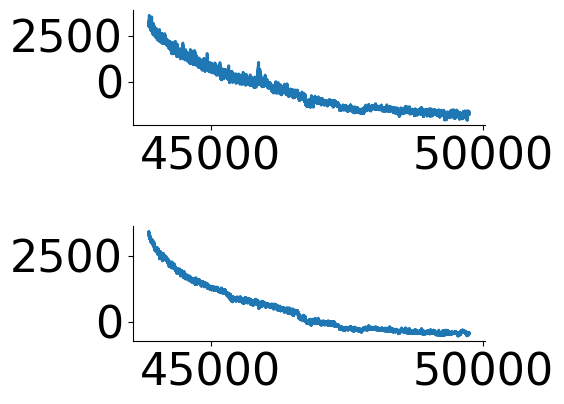

In [5]:
"""
There are:
Four "strains": "Saline", "Non-Selective", "D1-Cre", "A2a-Cre"
17 mice: "C97M1", "C97M2", "GA11", "GA12", "GAC3F1", "C97M3", "C97M4", "F491", "F488", "F490", "M484", "F692", "C79M1", "C79M2", "M456", "M521", "M524"
Not every mouse is in all treatment groups. For mapping please see "Formatting data for analysis" cell.
"""
strain = "Non-Selective"
mouse =  "GA11"

fig, ax = plt.subplots(2,1)
ax[0].plot(files[strain][mouse]["Time"], files[strain][mouse]["Fluorescence"])
ax[1].plot(files[strain][mouse]["Time"], files[strain][mouse]["Isosbestic"])

Pre-process photometry data

In [6]:
"""
The photometry data is processed in the following manner.
A linear regression is used to fit the isosbestic data to the gcamp signal (noise_hat). The gcamp signal is processed as follows.
    norm_gcamp = (raw_gcamp - noise_hat) / noise_hat
This is analogous to a df/f given that the noise_hat represents the floor of the gcamp signal (f0). Importantly, the regression is fit on the
baseline data, and this fitted regression is used for the calculation of the df/f of both the baseline and the post-MK801 data.
This signal is then filtered using a bandpass digital filter that allows frequencies >0.005, <6 HZ.
"""

p_data = {}
ts = {}
for strain in files:
    p_data[strain] = {}
    ts[strain] = {}
    for mouse in files[strain]:

        c_data = files[strain][mouse]
        
        c_ts = c_data["Time"].iloc[150:].to_numpy()
        c_isos = c_data["Isosbestic"].iloc[150:].to_numpy()
        c_gcamp = c_data["Fluorescence"].iloc[150:].to_numpy()
        c_sr = np.diff(c_ts).mean()
        
        regr = LinearRegression()
        regr.fit(c_isos.reshape(-1,1), c_gcamp.reshape(-1,1))
        c_hat = regr.predict(c_isos.reshape(-1,1))
        
        c_norm = c_gcamp - c_hat[:,0]
        c_norm_2 = butter_filter(c_norm, 'bandpass', (0.005, 6), (1/c_sr))
        z_norm = (c_norm_2 - c_norm_2.mean()) / c_norm_2.std()
    
        p_data[strain][mouse] = z_norm
        ts[strain][mouse] = c_ts

print("All photometry recordings where succesffully processed")

All photometry recordings where succesffully processed


Visualizing the processed data

Text(0, 0.5, 'Z-Score')

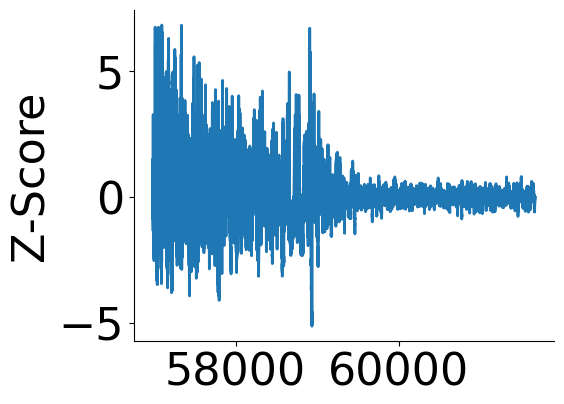

In [ ]:
"""
There are:
Four "strains": "Saline", "Non-Selective", "D1-Cre", "A2a-Cre"
17 mice: "C97M1", "C97M2", "GA11", "GA12", "GAC3F1", "C97M3", "C97M4", "F491", "F488", "F490", "M484", "F692", "C79M1", "C79M2", "M456", "M521", "M524"
Not every mouse is in all treatment groups. For mapping please see "Formatting data for analysis" cell.
"""

strain = "D1-Cre"
mouse =  "F490"

fig, ax = plt.subplots()
ax.plot(ts[strain][mouse], p_data[strain][mouse])
ax.set_ylabel("Z-Score")

Aligning the data to the injection

In [9]:
peh_ts = np.linspace(-900, 1800, 54000)
start = -900
end = 1800
aligned_data = {}
for strain in p_data:
    aligned_data[strain] = {}
    for mouse in p_data[strain]:
        c_ts = ts[strain][mouse]
        c_data = p_data[strain][mouse]
        c_metadata = metadata[np.logical_and(metadata["Mouse"]==mouse, metadata["Strain"]==strain)]
        c_inj = [c_metadata["Injection_time"]]
        
        c_peh = contvar_peh(c_ts, c_data, c_inj, (start,end), 0.05)[0,:]
        aligned_data[strain][mouse] = c_peh

print("All data was successfully aligned")

All data was successfully aligned


Finding peaks in the calcium recordings

In [11]:
widths = np.arange(1,160)
min_snr = 6
prominence = 1
        
#Find all peaks in all the recordings
all_peaks = {}
all_peak_ts = {}
all_peak_proms = {}
for strain in aligned_data:
    all_peaks[strain] = {}
    all_peak_ts[strain] = {}
    all_peak_proms[strain] = {}
    for mouse in aligned_data[strain]:
        c_data = aligned_data[strain][mouse]
        c_peaks = find_peaks(c_data, prominence=3)
        c_peak_ts = peh_ts[c_peaks[0]]
        all_peaks[strain][mouse] = c_peaks[0]
        all_peak_ts[strain][mouse] = c_peak_ts
        all_peak_proms[strain][mouse] = c_peaks[1]["prominences"]

print("All peaks were successfully found")

All peaks were successfully found


Visualizing traces with peaks

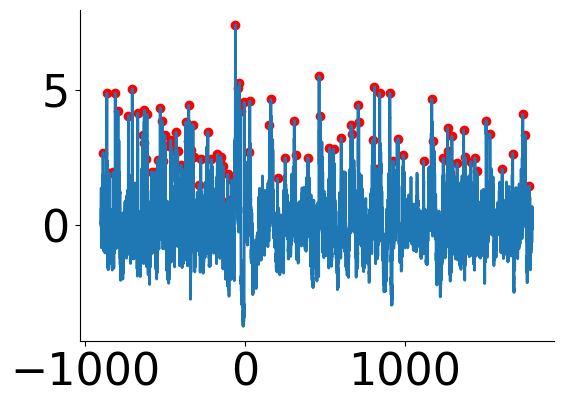

In [12]:
"""
There are:
Four "strains": "Saline", "Non-Selective", "D1-Cre", "A2a-Cre"
17 mice: "C97M1", "C97M2", "GA11", "GA12", "GAC3F1", "C97M3", "C97M4", "F491", "F488", "F490", "M484", "F692", "C79M1", "C79M2", "M456", "M521", "M524"
Not every mouse is in all treatment groups. For mapping please see "Formatting data for analysis" cell.
"""

strain = "Saline"
mouse = "GA12"

#Visualize peaks
fig, ax = plt.subplots()
ax.plot(peh_ts, aligned_data[strain][mouse])
ax.scatter(peh_ts[all_peaks[strain][mouse]], aligned_data[strain][mouse][all_peaks[strain][mouse]], c="red")

Calculating the transient rate in 5 minute bins

[Text(0, 0, 'Sal'), Text(1, 0, 'N.S.'), Text(2, 0, 'D1'), Text(3, 0, 'A2a')]

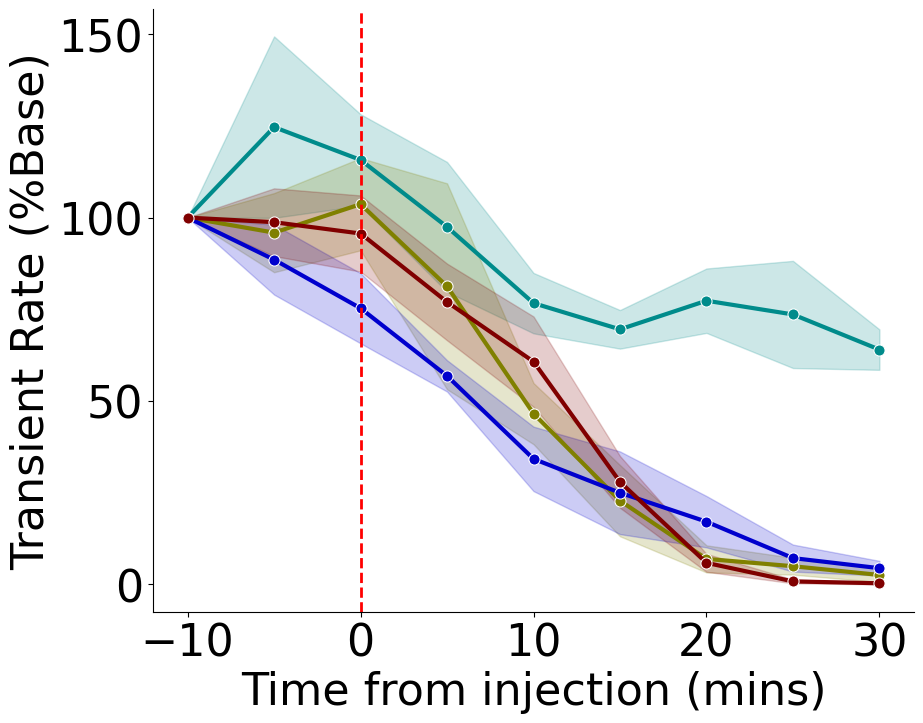

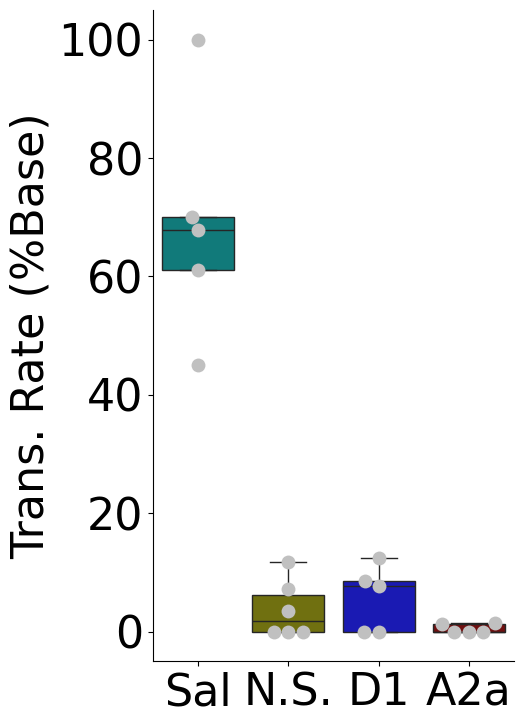

In [14]:
"""
The transient rate in the post-injection period is normalized to the transient rate in the baseline period to control
for gcamp expression and other variability sources between mice.
"""

bins = np.arange(-900, 1801, 300)
all_peak_hist = []
for strain in all_peaks:
    for mouse in all_peak_ts[strain]:
        c_peak_ts = all_peak_ts[strain][mouse]
        c_peak_hist = np.histogram(c_peak_ts, bins=bins)[0]
        c_peak_hist = (c_peak_hist / c_peak_hist[0]) * 100
        c_peak_hist_df = pd.DataFrame(c_peak_hist)
        c_peak_hist_df = c_peak_hist_df.assign(Bin=np.arange(-10,31,5), Strain=strain, Mouse=mouse)
        m_c_peak_hist_df  = pd.melt(c_peak_hist_df, id_vars=["Bin", "Strain", "Mouse"])
        all_peak_hist.append(m_c_peak_hist_df)
                
concat_peak_hist = pd.concat(all_peak_hist)
concat_peak_hist["Strain"] = pd.Categorical(concat_peak_hist["Strain"], ordered=True, categories=strains)


#Plotting of peak rate over time
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x="Bin", y="value", hue="Strain", data=concat_peak_hist, errorbar="se", marker="o", palette=["darkcyan", "olive", "mediumblue", "maroon"], 
             markersize=8, linewidth=3, legend=False)
ax.set_xlabel("Time from injection (mins)")
ax.set_ylabel("Transient Rate (%Base)")
ax.axvline(0, c="red", linestyle="--", linewidth=2)
sns.despine()

#Now we quantify and plot the tansient in the last 10 minutes
last_10_peak_hist = concat_peak_hist[concat_peak_hist["Bin"] > 21]
last_10_peak_hist = last_10_peak_hist.groupby(["Strain", "Mouse"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(6,8))
sns.boxplot(x="Strain", y="value", data=last_10_peak_hist, palette=["darkcyan", "olive", "mediumblue", "maroon"])
sns.swarmplot(x="Strain", y="value", data=last_10_peak_hist, c="silver", size=10)
ax.set_xlabel("")
ax.set_ylabel("Trans. Rate (%Base)")
sns.despine()
ax.set_xticklabels(["Sal", "N.S.", "D1", "A2a"])